In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv("time series fix.csv")

dataframe.info()
print(dataframe.isna().sum().sort_values())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      365 non-null    object
 1   sum(qty)  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB
date        0
sum(qty)    0
dtype: int64


In [3]:
dataframe['date'] = pd.to_datetime(dataframe['date'])

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      365 non-null    datetime64[ns]
 1   sum(qty)  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [4]:
dataframe.drop_duplicates(inplace = True)

dataframe.duplicated().sum()

0

In [5]:
dataframe.isnull().sum()

date        0
sum(qty)    0
dtype: int64

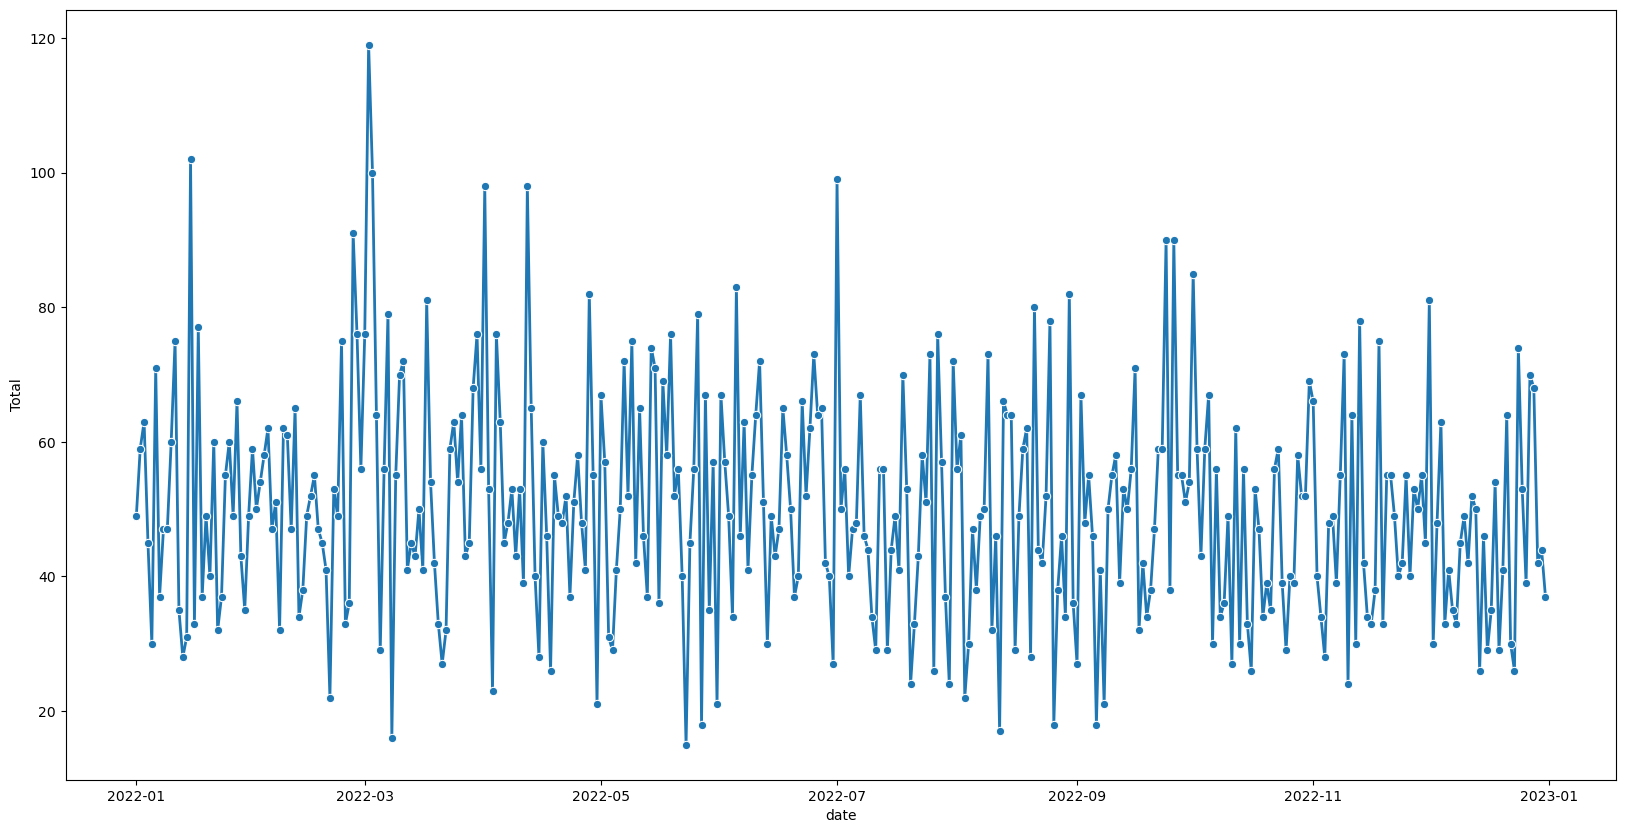

In [6]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=dataframe, x='date', y='sum(qty)', linewidth=2, marker='o')

plt.ylabel('Total')

plt.show()

In [7]:
rolling_mean = dataframe["sum(qty)"].rolling(5).mean()
rolling_std = dataframe["sum(qty)"].rolling(5).std()

print(rolling_mean)
print(rolling_std)


0       NaN
1       NaN
2       NaN
3       NaN
4      49.2
       ... 
360    52.4
361    60.8
362    54.4
363    52.6
364    52.2
Name: sum(qty), Length: 365, dtype: float64
0            NaN
1            NaN
2            NaN
3            NaN
4      12.969194
         ...    
360    20.329781
361    14.549914
362    14.328294
363    15.093045
364    15.562776
Name: sum(qty), Length: 365, dtype: float64


([], [])

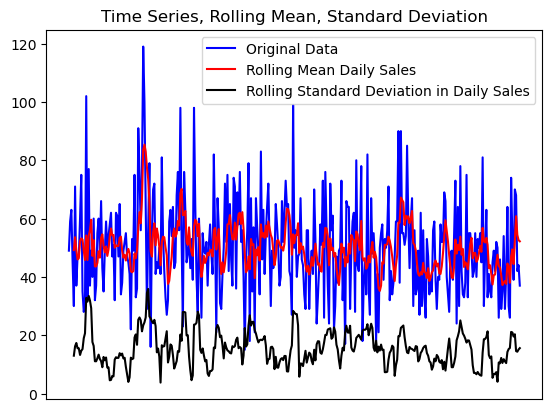

In [8]:
plt.plot(dataframe['date'], dataframe['sum(qty)'], color="blue", label="Original Data")
plt.plot(dataframe['date'], rolling_mean, color="red", label="Rolling Mean Daily Sales")
plt.plot(dataframe['date'], rolling_std, color="black", label="Rolling Standard Deviation in Daily Sales")

plt.title("Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.xticks([])

In [9]:
autocorrelation_lag360 = dataframe['sum(qty)'].autocorr(lag=12)
print("one year lag: ", autocorrelation_lag360)

one year lag:  0.051930700025633186


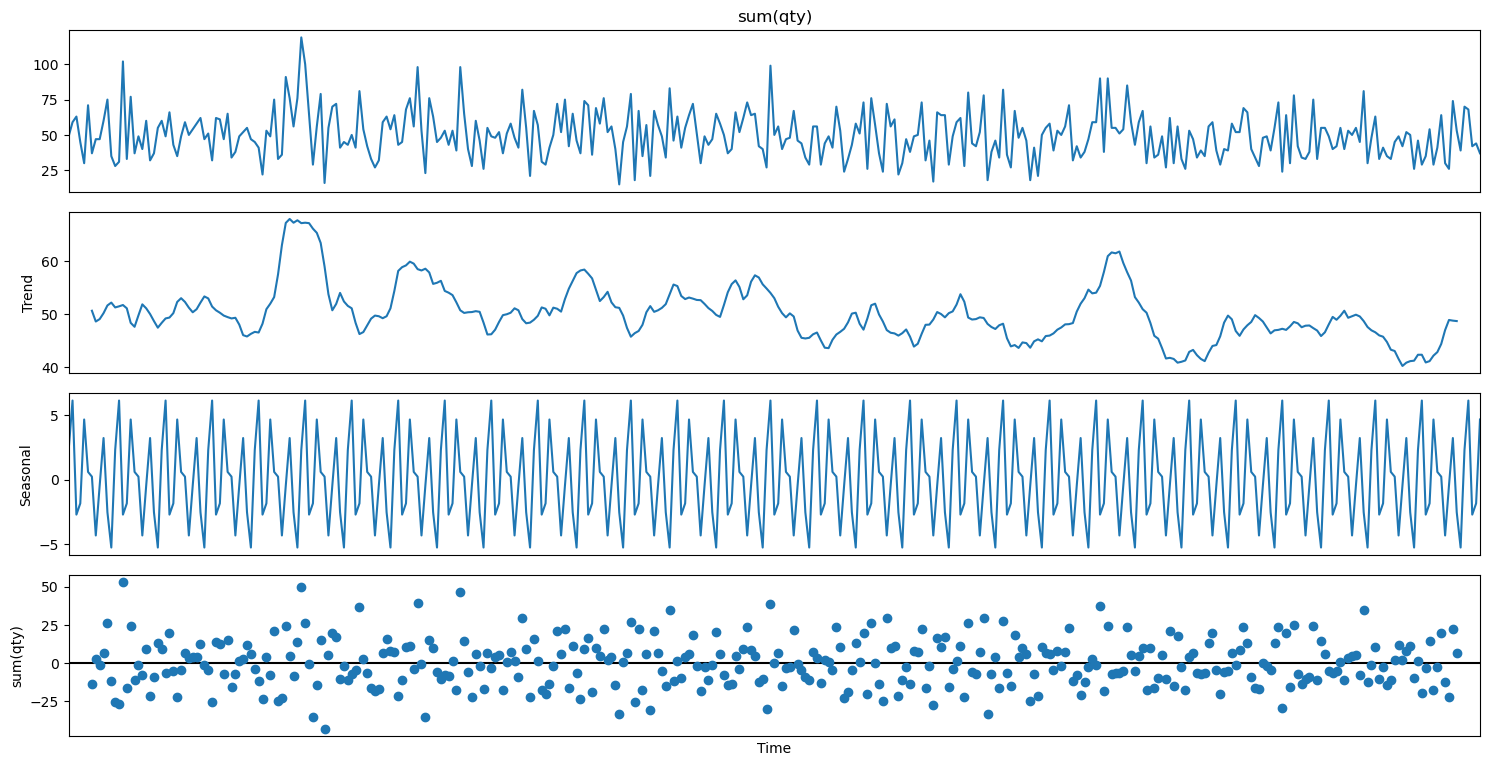

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(dataframe['sum(qty)'],model='additive', period=12)
decompose.plot()
plt.gcf().set_size_inches(15, 8)
plt.xlabel('Time')
plt.ylabel('sum(qty)')
plt.tight_layout()
plt.xticks([])
plt.show()


In [11]:
print(dataframe)

          date  sum(qty)
0   2022-01-01        49
1   2022-01-02        59
2   2022-01-03        63
3   2022-01-04        45
4   2022-01-05        30
..         ...       ...
360 2022-12-27        70
361 2022-12-28        68
362 2022-12-29        42
363 2022-12-30        44
364 2022-12-31        37

[365 rows x 2 columns]


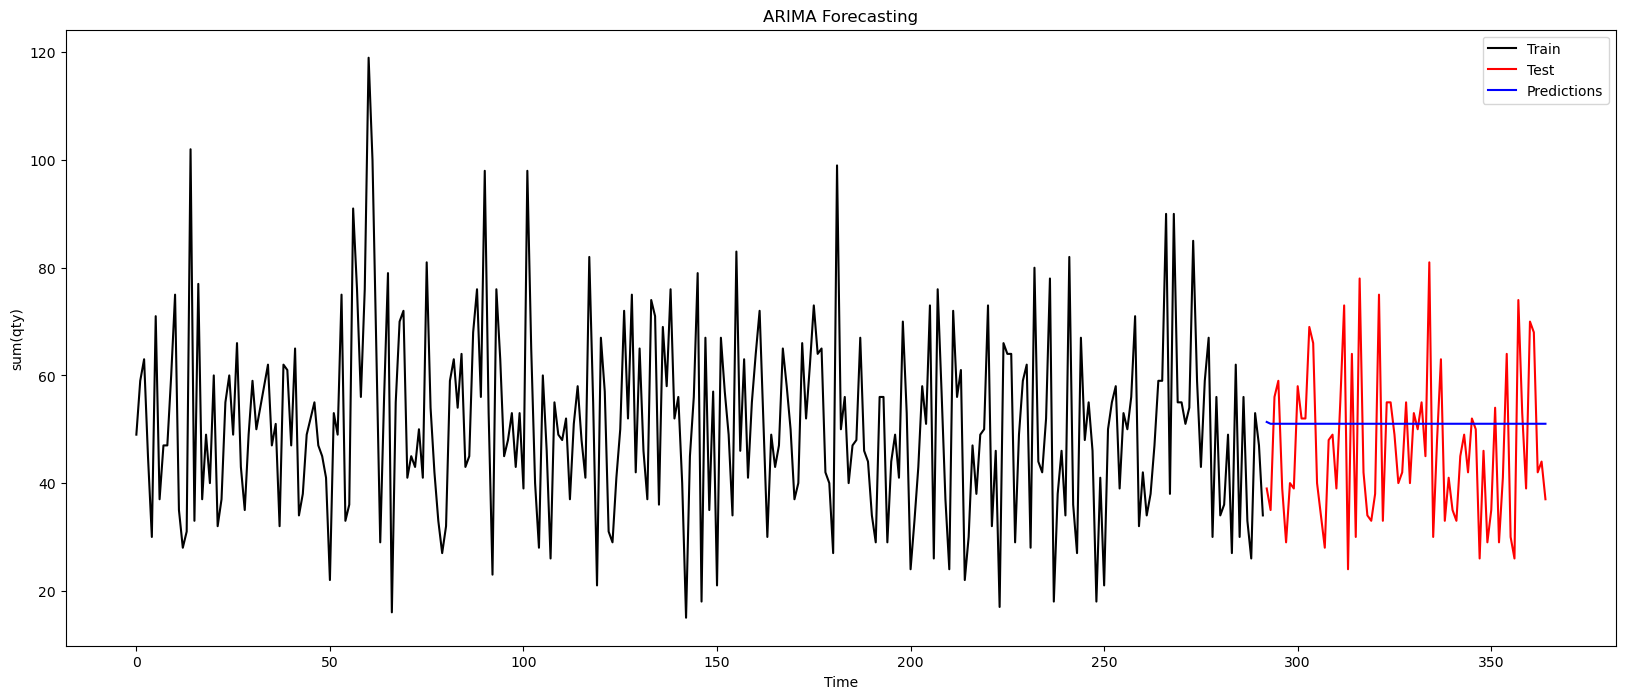

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


train, test = train_test_split(dataframe, test_size=0.2, shuffle=False)


order = (1, 0, 0)

y_train = train['sum(qty)']
y_test = test['sum(qty)']

final_model = ARIMA(y_train, order=order)
final_model_fit = final_model.fit()

predictions = final_model_fit.predict(start=test.index.min(), end=test.index.max())

plt.figure(figsize=(20, 8))
plt.plot(train.index, train['sum(qty)'], color='black', label='Train')
plt.plot(test.index, test['sum(qty)'], color='red', label='Test')
plt.plot(test.index, predictions, color='blue', label='Predictions')
plt.ylabel('sum(qty)')
plt.xlabel('Time')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()


In [13]:
final_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               sum(qty)   No. Observations:                  292
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1245.208
Date:                Sat, 07 Oct 2023   AIC                           2496.416
Time:                        10:26:55   BIC                           2507.446
Sample:                             0   HQIC                          2500.834
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.0213      1.049     48.641      0.000      48.965      53.077
ar.L1         -0.0196      0.050     -0.392      0.695      -0.118       0.079
sigma2       296.1731     22.714     13.039      0.000     251.655     340.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.15
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.55
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Calculate the RMSE

In [14]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(rmse)

14.503091674258643
